# PyPoT Example Code

This notebook includes example code for performing peaks-over-threshold analysis tasks using PyPoT.

## 1a) simulate Generalized Pareto data and fit distribution parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pypot.generalized_pareto import gp_inv_cdf, fit_GPD, gp_density

In [9]:
# true parameters
XI = -0.20
SIGMA = 0.75
# number of simulations
N_SIM = 10000

u_vals = np.random.uniform(size=N_SIM)
# probability integral transform data
x_vals = gp_inv_cdf(u_vals, XI, SIGMA)

# initial parameter guess
XI_INIT = 1/8
SIGMA_INIT = 1
THETA_0 = (XI_INIT, SIGMA_INIT)

# fit the distribution via MLE (minimizing negative log likelihood)
mle = fit_GPD(x_vals, THETA_0, gp_neg_loglik, gp_neg_loglik_jacob)

print("maximum likelihood estimates of xi, sigma:")
print(mle)

Optimization terminated successfully
maximum likelihood estimates of xi, sigma:
[-0.20873331  0.75477028]


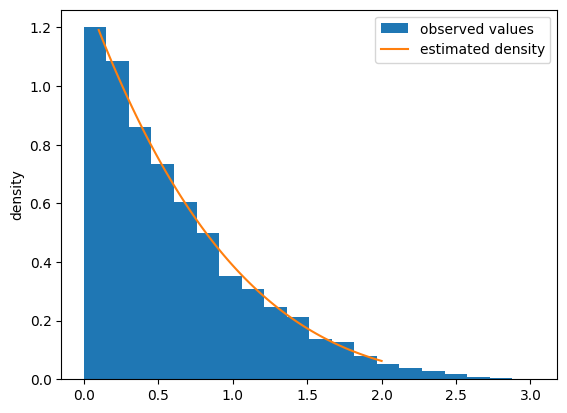

In [10]:
plt.hist(x_vals, density=True, label="observed values", bins=20)

# MLE ESTIMATE
x_plot = np.linspace(0.1, 2, 100)
y_plot = gp_density(x_plot, mle[0], mle[1])
plt.plot(x_plot, y_plot, label="estimated density")
plt.ylabel("density", fontsize=10)
plt.legend()

plt.show()

## 1b) compute confidence intervals for GP parameters

In [12]:
from pypot.generalized_pareto import gp_param_cov_matrix

In [17]:
xi_hat = mle[0]
sigma_hat = mle[1]

# compute covariance matrix of estimators
estimator_cov_mat = gp_param_cov_matrix(xi_hat, sigma_hat, N_SIM)

confint_xi = [xi_hat - 1.96 * np.sqrt(estimator_cov_mat[0][0]), xi_hat + 1.96 * np.sqrt(estimator_cov_mat[0][0])]
print("confidence interval for xi:")
print(confint_xi)

confint_sigma = [sigma_hat - 1.96 * np.sqrt(estimator_cov_mat[1][1]), sigma_hat + 1.96 * np.sqrt(estimator_cov_mat[1][1])]
print("confidence interval for sigma:")
print(confint_sigma)


confidence interval for xi:
[-0.2279015753159071, -0.18956504943691976]
confidence interval for sigma:
[0.7361602404635179, 0.773380320020608]


## 2)a load example time series dataset, and fit the GPD given a threshold u=3.5

In [2]:
from pypot.utils import fetch_example_dataset

series = fetch_example_dataset()
series.head()

Datetime
1942-01-01 01:00:00    2.088638
1942-01-01 02:00:00    2.056474
1942-01-01 03:00:00    2.063103
1942-01-01 04:00:00    2.124239
1942-01-01 05:00:00    2.170153
Name: swell_height, dtype: float32

In [7]:
from pypot.utils import get_extremes_peaks_over_threshold
from pypot.generalized_pareto import gp_neg_loglik, gp_neg_loglik_jacob, fit_GPD
from pypot.threshold_selection import anderson_darling_statistic, log_interpolate_p


In [10]:
# initial point for optimizer
XI_INIT = 1/5
SIGMA_INIT = 1
THETA_0 = (XI_INIT, SIGMA_INIT)

# threshold
u = 3.5
# independence time delta
r = "72h"

extremes = get_extremes_peaks_over_threshold(
    series,
    u,
    r
)
x_vals = extremes - u

# fit GPD
mle = fit_GPD(
    x_vals,
    THETA_0,
    gp_neg_loglik,
    gp_neg_loglik_jacob  # use analytical Jacobian of negative log likelihood
)
xi_hat = mle[0]
sigma_hat = mle[1]

print("mle for xi, sigma:")
print(mle)

Optimization terminated successfully
mle for xi, sigma:
[-0.0694401   0.70032931]


## 2b) compute 50 year return level and variance of this estimator

In [21]:
from pypot.return_levels import lambda_hat, r_hat, var_hat_r_l
from pypot.utils import years_span_series

# Poisson process lambda MLE
lambda_hat = lambda_hat(extremes)
print("mle for lambda:")
print(lambda_hat)

mle for lambda:
9.551684766061097


In [22]:
L = 50

r_hat_50 = r_hat(L, lambda_hat, xi_hat, sigma_hat)
print("estimated 50 year return value:")
# add back the subtracted threshold
print(r_hat_50 + u)

estimated 50 year return value:
7.0139645276448


In [24]:
# sample size
n = len(extremes)
# time spanned by the series in years
t = years_span_series(series)
print("sample size:")
print(n)
print("years span:")
print(t)

# asymptotic variance of 50 year return value
var_L = var_hat_r_l(lambda_hat, xi_hat, sigma_hat, n, t, L)

sd = np.sqrt(var_L)

print("50 year return variance:")
print(var_L)
print("50 year standard deviation")
print(sd)

# compute 90% confidence interval
Z_SCORE = 1.645

lower_bound = u + r_hat_50 -  Z_SCORE * sd
upper_bound = u + r_hat_50 + Z_SCORE * sd

print("50 year return value:")
print(u + r_hat_50)

print("90% CI:")
print(lower_bound)
print(upper_bound)


sample size:
773
years span:
80.99657768651609
50 year return variance:
[[0.07529988]]
50 year standard deviation
[[0.27440823]]
50 year return value:
7.0139645276448
90% CI:
[[6.56256299]]
[[7.46536606]]


## 3) automated threshold selection using ForwardStop algorithm TODO

In [4]:
from pypot.utils import fetch_adquantiles_table

adq_frame = fetch_adquantiles_table()

adq_frame.head()

,0.999,0.998,0.997,0.996,0.995,0.994,0.993,0.992,0.991,0.990,...,0.010,0.009,0.008,0.007,0.006,0.005,0.004,0.003,0.002,0.001
-0.50,0.121223,0.130634,0.136941,0.141757,0.145754,0.149320,0.152513,0.155372,0.158035,0.160396,...,1.815296,1.855035,1.900066,1.951018,2.009175,2.078208,2.162929,2.274349,2.428954,2.687376
-0.49,0.120954,0.129964,0.136542,0.141501,0.145458,0.149032,0.152169,0.155076,0.157542,0.160011,...,1.802558,1.840593,1.883786,1.934147,1.991703,2.060843,2.141207,2.252637,2.403623,2.668255
-0.48,0.120897,0.129783,0.136012,0.141052,0.145088,0.148721,0.151819,0.154560,0.157240,0.159648,...,1.805332,1.844551,1.888966,1.939759,1.998315,2.065278,2.150447,2.259846,2.415750,2.684926
-0.47,0.120957,0.130218,0.136572,0.141155,0.145169,0.148566,0.151690,0.154501,0.157026,0.159378,...,1.794760,1.832802,1.874531,1.923271,1.979416,2.046796,2.132830,2.242718,2.391125,2.656508
-0.46,0.120667,0.129645,0.135927,0.140742,0.144719,0.148231,0.151399,0.154090,0.156632,0.159051,...,1.780905,1.819220,1.862746,1.912246,1.969153,2.036977,2.119286,2.226101,2.383369,2.645597


## TODO

In [16]:
from pypot.utils import get_extremes_peaks_over_threshold
from pypot.generalized_pareto import negative_log_likelihood, gpd_neg_loglik_jacob, fit_GPD
from pypot.threshold_selection import anderson_darling_statistic, log_interpolate_p

import numpy as np
import pandas as pd
import time

In [20]:
XI_INIT = 1/5
SIGMA_INIT = 1
THETA_0 = (XI_INIT, SIGMA_INIT)


# candidate thresholds
thresholds = np.linspace(2, 6, 41)


p_vals = np.zeros(len(thresholds))

start = time.time()

for i, cand_threshold in enumerate(thresholds):
    # get extremes corresponding to threshold

    extremes = get_extremes_peaks_over_threshold(
        series,
        cand_threshold,
        "72h"
    )
    x_cand = extremes - cand_threshold
    
    # fit GPD
    mle_cand = fit_GPD(
        x_cand,
        THETA_0,
        negative_log_likelihood,
        gpd_neg_loglik_jacob
    )
    xi_hat_cand = mle_cand[0]

    sigma_hat_cand = mle_cand[1]
    # AD statistic
    ad_stat_cand = anderson_darling_statistic(x_cand, xi_hat_cand, sigma_hat_cand)
    #print(ad_stat_cand)

    # p-value of AD test
    p_cand = log_interpolate_p(ad_stat_cand, round(xi_hat_cand, 2), adq_frame)
    #print(p_cand)

    p_vals[i] = p_cand

end = time.time()
print("time elapsed:")
print(end - start)

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
O

In [21]:
p_vals

array([0.03321332, 0.05057733, 0.00446351, 0.02427211, 0.00397254,
       0.05314345, 0.12504479, 0.3917399 , 0.2462355 , 0.1332721 ,
       0.10909977, 0.27933083, 0.58128567, 0.25128944, 0.82583675,
       0.68296883, 0.9088945 , 0.53063972, 0.8398362 , 0.65898103,
       0.6035582 , 0.66045163, 0.40005944, 0.48455812, 0.39045476,
       0.1865241 , 0.05410365, 0.3612263 , 0.20902934, 0.31497136,
       0.13228578, 0.04775941, 0.06445734, 0.57157274, 0.47469029,
       0.34600219, 0.6271129 , 0.28469627, 0.33567391, 0.74369551,
       0.57556056])